# CNN Experiments on muvr data

First we need to setup the environment and import all the necessary stuff.

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import shutil
import numpy as np
from os import remove
import cPickle as pkl
from os.path import expanduser, exists
import os
import sys
import logging

logging.basicConfig(level=10)
logger = logging.getLogger()

# Add the mlp python src director to the import search path
mlp_folder = "../mlp"
sys.path.append(os.path.abspath(mlp_folder))

# Now we are able to use all the packages defined in mlp_folder
# import training.acceleration_dataset

This time we are not going to generate the data but rather use real world annotated training examples.

In [2]:
from training.acceleration_dataset import CSVAccelerationDataset

exercise_mapping = {
    "arms/biceps-curl" : ["biceps curls (left)", "biceps-curl", "bice", "arms/biceps-curl", "BC ", "bicep curls", "bicep"],
    "arms/triceps-extension" : ["arms/lateral-raise", "lateral raises", "lateral", "lateral-raise", "LR", "LR "],
    "shoulders/lateral-raise" : ["triceps-extension	", "tc ", "TE", "tc", "triceps-extension"],
    "-" : ["walking", ""]
}    
 
inv_exercise_map = dict((label, ex) for (ex,labels) in exercise_mapping.iteritems() for label in labels)    

def label_mapper(label):
    return inv_exercise_map.get(label)  

model_name = "slacking"
working_directory = "cnn-ac-models"
dataset = CSVAccelerationDataset('datasets/tmbo/', label_mapper=label_mapper)

print "Number of training examples:", dataset.num_train_examples
print "Number of test examples:", dataset.num_test_examples
print "Number of features:", dataset.num_features
print "Number of labels:", dataset.num_labels

Number of training examples: 157640
Number of test examples: 69608
Number of features: 1200
Number of labels: 4


At first we want to inspect the class distribution of the training and test examples.

In [3]:
from ipy_table import *
from operator import itemgetter

def calculate_dist(labels):
    dist = np.zeros((dataset.num_labels, 1))
    for i in range(0, len(labels)):
        dist[labels[i], 0] += 1
    return dist

train_dist = calculate_dist(dataset.y_train)
test_dist = calculate_dist(dataset.y_test)

train_ratio = train_dist / dataset.num_train_examples
test_ratio = test_dist / dataset.num_test_examples

overall = train_dist + test_dist
overall_ratio = overall * 1.0 / (dataset.num_train_examples + dataset.num_test_examples)


# Fiddle around to get it into table shape
table = np.hstack((np.zeros((dataset.num_labels,1), dtype=int), train_dist, train_ratio, test_dist, test_ratio, overall, overall_ratio))
table = np.vstack((np.zeros((1, 7), dtype=int), table)).tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_labels))

for i,s in enumerate(human_labels):
    table[i + 1][0] = s
    
table.sort(lambda x,y: cmp(x[1], y[1]))

table[0][0] = ""
table[0][1] = "Train"
table[0][2] = "Train %"
table[0][3] = "Test"
table[0][4] = "Test %"
table[0][5] = "Overall"
table[0][6] = "Overall %"

make_table(table)
set_global_style(float_format='%0.0f', align="center")
set_column_style(2, float_format='%0.2f%%')
set_column_style(4, float_format='%0.2f%%')
set_column_style(6, float_format='%0.2f%%')
set_column_style(0, align="left")

,Train,Train %,Test,Test %,Overall,Overall %
arms/triceps-extension,12860,0.08%,4297,0.06%,17157,0.08%
shoulders/lateral-raise,14600,0.09%,3421,0.05%,18021,0.08%
arms/biceps-curl,22877,0.15%,3197,0.05%,26074,0.11%
-,107303,0.68%,58693,0.84%,165996,0.73%


Let's have a look at the generated data. We will plot some of the examples of the different classes.

Ids of plotted examples: [146158  76707  14119]


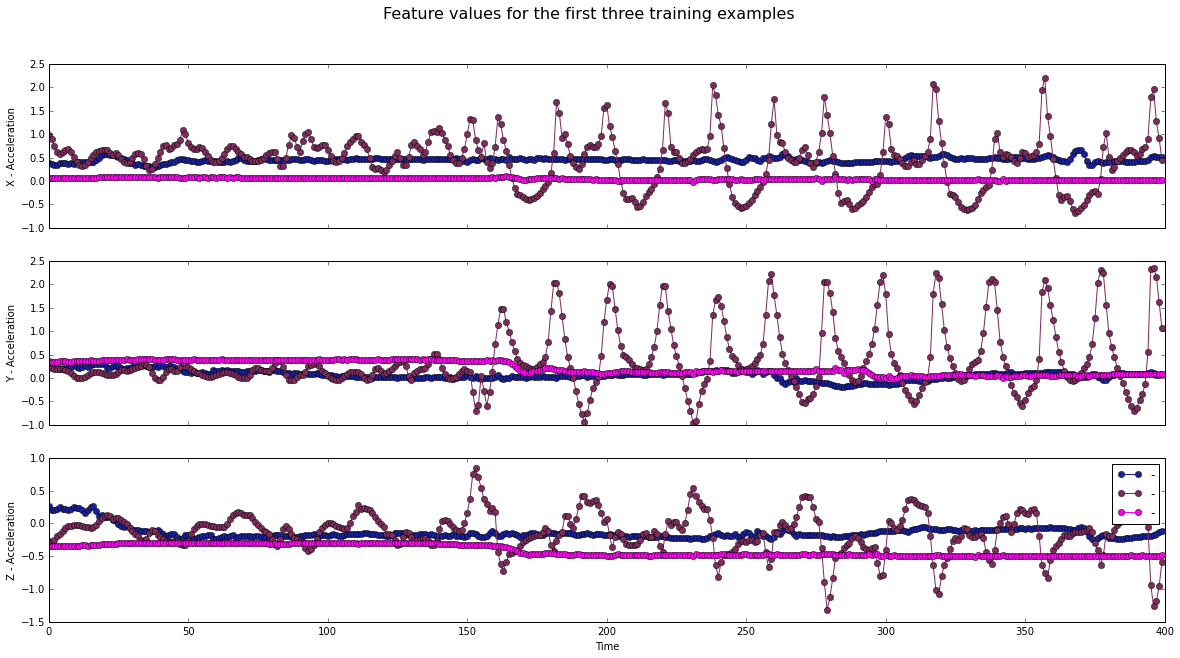

In [4]:
from matplotlib import pyplot, cm
from pylab import *

# Choose some random examples to plot from the training data
number_of_examples_to_plot = 3
plot_ids = np.random.random_integers(0, dataset.num_train_examples - 1, number_of_examples_to_plot)

print "Ids of plotted examples:",plot_ids

# Retrieve a human readable label given the idx of an example
def label_of_example(i):
    return dataset.human_label_for(dataset.y_train[i])

figure(figsize=(20,10))
ax1 = subplot(311)
setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('X - Acceleration')

ax2 = subplot(312, sharex=ax1)
setp(ax2.get_xticklabels(), visible=False)
ax2.set_ylabel('Y - Acceleration')

ax3 = subplot(313, sharex=ax1)
ax3.set_ylabel('Z - Acceleration')

for i in plot_ids:
    c = np.random.random((3,))

    ax1.plot(range(0, dataset.num_features / 3), dataset.X_train[i,0:400], '-o', c=c)
    ax2.plot(range(0, dataset.num_features / 3), dataset.X_train[i,400:800], '-o', c=c)
    ax3.plot(range(0, dataset.num_features / 3), dataset.X_train[i,800:1200], '-o', c=c)
    
legend(map(label_of_example, plot_ids))
suptitle('Feature values for the first three training examples', fontsize=16)
xlabel('Time')
show()

Now we are going to create a neon model. We will start with a realy simple one layer preceptron having 500 hidden units.

In [5]:
from training.mlp_model import MLPMeasurementModelTrainer
from neon.layers import *
from neon.models import Model
from neon.transforms import Rectlin, Tanh, Logistic
from neon.initializers import Uniform, Constant
    
init_norm = Uniform(low=-0.1,high=0.1)
bias_init = Constant(val = 1.0)    

layers = []

layers.append(Conv(
    fshape = (1, 3, 16),
    init=init_norm,
    bias=bias_init,
    activation=Rectlin()))

layers.append(Pooling(
    op="max",
    fshape=(2,1),
    strides=2))

layers.append(Conv(
    fshape = (1, 3, 32),
    init=init_norm,
    bias=bias_init,
    activation=Rectlin()))

layers.append(Pooling(
    op="max",
    fshape=(2,1),
    strides=2))

layers.append(Affine(
    nout=100,
    init=init_norm,
    bias=bias_init,
    activation=Rectlin()))

layers.append(Dropout(
    name="do_2",
    keep = 0.9))

layers.append(Affine(
    nout=dataset.num_labels,
    init=init_norm,
    bias=bias_init,
    activation = Logistic()))

mlpmodel = MLPMeasurementModelTrainer(working_directory, lrate=0.01, max_epochs=20)

model = mlpmodel.train(dataset, Model(layers=layers))

Epochs: 20 Batch-Size: 30
Starting training...
[1200, 'id', 'relu', 'relu', 100, 'relu', 4, 'logistic']


ValueError: negative dimensions are not allowed

To check weather the network is learning something we will plot the weight matrices of the different training epochs.

In [ ]:
import numpy as np
import math
from matplotlib import pyplot, cm
from pylab import *
from IPython.html import widgets
from IPython.html.widgets import interact

def closestSqrt(i):
    N = int(math.sqrt(i))
    while True:
        M = int(i / N)
        if N * M == i:
            return N, M
        N -= 1
        
def plot_filters(**kwargs):
    n = kwargs['n']
    layer_name = kwargs['layer']
    dest_path = expanduser('~/data/workout-cnn/workout-ep' + str(n) + '.prm')
    params = pkl.load(open(dest_path, 'r'))

    wts = params[layer_name]['weights']

    nrows, ncols = closestSqrt(wts.shape[0])
    fr, fc = closestSqrt(wts.shape[1])
    
    fi = 0

    W = np.zeros((fr*nrows, fc*ncols))
    for row, col in [(row, col) for row in range(nrows) for col in range(ncols)]:
        W[fr*row:fr*(row+1):,fc*col:fc*(col+1)] = wts[fi].reshape(fr,fc)
        fi = fi + 1

    matshow(W, cmap=cm.gray)
    title('Visualizing weights of '+layer_name+' in epoch ' + str(n) )
    show()
    
layer_names = map(lambda l: l[1].name+"_"+str(l[0]), filter(lambda l: l[1].has_params, enumerate(model.layers)))

_i = interact(plot_filters,
              layer=widgets.widget_selection.ToggleButtons(options = layer_names),
              n=widgets.IntSliderWidget(description='epochs',
                                        min=0, max=max_epochs, value=0, step=epoch_step_size))



In [ ]:
print "Lowest test error: %0.2f%%" % np.min(test_err)
print "Lowest train error: %0.2f%%" % np.min(train_err)

pyplot.plot(range(epoch_step_size*26, max_epochs+1, epoch_step_size), train_err, linewidth=3, label='train')
pyplot.plot(range(epoch_step_size*26, max_epochs+1, epoch_step_size), test_err, linewidth=3, label='test')
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("error %")
pyplot.show()

Let's also have a look at the confusion matrix for the test dataset.

In [ ]:
from sklearn.metrics import confusion_matrix
from ipy_table import *

# confusion_matrix(y_true, y_pred)
predicted, actual = model.predict_fullset(dataset, "test")

y_pred = np.argmax(predicted.asnumpyarray(), axis = 0) 
y_true = np.argmax(actual.asnumpyarray(), axis = 0) 

confusion_mat = confusion_matrix(y_true, y_pred, range(0,dataset.num_labels))

# Fiddle around with cm to get it into table shape
confusion_mat = vstack((np.zeros((1,dataset.num_labels), dtype=int), confusion_mat))
confusion_mat = hstack((np.zeros((dataset.num_labels + 1, 1), dtype=int), confusion_mat))

table = confusion_mat.tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_labels))

for i,s in enumerate(human_labels):
    table[0][i+1] = s
    table[i+1][0] = s

table[0][0] = "actual \ predicted"

mt = make_table(table)
set_row_style(0, color='lightGray', rotate = "315deg")
set_column_style(0, color='lightGray')
set_global_style(align='center')

for i in range(1, dataset.num_labels + 1):
    for j in range(1, dataset.num_labels + 1):
        if i == j:
            set_cell_style(i,j, color='lightGreen', width = 80)
        elif table[i][j] > 20:
            set_cell_style(i,j, color='Pink')
        elif table[i][j] > 0:
            set_cell_style(i,j, color='lightYellow')
mt